In [6]:
import numpy as np
import albumentations as albu
import json
import cv2
from datetime import datetime

import sys
sys.path.append('../preprocess/data_loader')
import matplotlib.pyplot as plt
from data_loader import DataLoader
import torch
from datasets import Dataset, DatasetDict, Features, Value, Image, Sequence, ClassLabel
from PIL import ImageDraw
from PIL import Image as ImagePil
from transformers import AutoModelForImageClassification
from transformers import AutoImageProcessor
from transformers import TrainingArguments, Trainer, DefaultDataCollator

# For evaluate
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, RandomAffine
from transformers import pipeline
import evaluate
from tqdm import tqdm
import torchvision
import os

2023-05-21 19:37:36.549455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Detectron2 not imported


In [7]:
#CBIS = "/workspace/data/Mammographies/CBIS-DDSM"
#MIAS = "/workspace/data/Mammographies/MIAS"
#INBREAST = "/workspace/data/Mammographies/INBreast"

#loader = DataLoader(INBREAST, MIAS, CBIS)
loader = DataLoader()

features = Features({
    'image': Image(decode=True, id=None),
    'label': ClassLabel(names=["B","M"], id=None)
})


dataset = Dataset.from_generator(loader.classification_generator(target_library="hugging_face",
                                                                 output_size=(400,400)),
                                 features=features,
                                 cache_dir="./dataset_class_cache",
                                 )


Found cached dataset generator (/tf/code/vit-classification/dataset_class_cache/generator/default-2fd804b061811f28/0.0.0)


In [8]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=400x400>,
 'label': 0}

In [9]:
dataset=dataset.shuffle()

In [10]:
# 90% train, 10% test + validation
train_testvalid = dataset.train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8702
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1088
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 1088
    })
})

In [6]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['B', 'M'], id=None)}

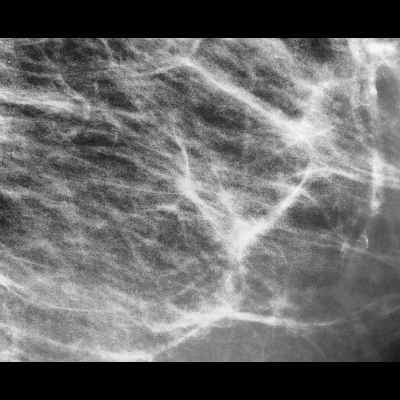

In [7]:
dataset["train"][0]["image"]

In [11]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
id2label[dataset["train"][0]["label"]], dataset["train"][0]["label"]

('B', 0)

In [12]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [13]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size),
                       RandomAffine(degrees=90,translate=(0.25,0.25),scale=(0.8,1)),
                       ToTensor(),
                       normalize])

In [14]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [15]:
ds = dataset.with_transform(transforms)

# Search Hyperparameters

In [13]:
data_collator = DefaultDataCollator()

In [14]:
accuracy = evaluate.load("accuracy")

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [16]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps",
                                                                [1, 2, 4, 8]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size",
                                                                [1,2,4,8]),
        "warmup_ratio": trial.suggest_float("warmup_ratio",0.1,0.5,step=0.05),
    }

def model_init(trial):     
    return AutoModelForImageClassification.from_pretrained(
        checkpoint,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
    )

In [17]:
training_args = TrainingArguments(
    output_dir="hyper_params",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=None,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["valid"],
    tokenizer=image_processor,
    model_init=model_init,
    compute_metrics=compute_metrics,
)

trainer.train()

best_trial = trainer.hyperparameter_search(
    direction="maximize", #default metric is loss
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=10,
)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']


Epoch,Training Loss,Validation Loss,Accuracy
1,0.652100,0.548841,0.732537


[I 2023-05-21 08:33:09,738] A new study created in memory with name: no-name-877c7390-63eb-410f-ae57-b43d31e24ad3
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy
1,0.653300,0.548975,0.739890


[I 2023-05-21 09:23:44,034] Trial 0 finished with value: 0.7398897058823529 and parameters: {'learning_rate': 1.3405801148711837e-05, 'weight_decay': 9.90693161382277e-06, 'gradient_accumulation_steps': 1, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.30000000000000004}. Best is trial 0 with value: 0.7398897058823529.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weight

Epoch,Training Loss,Validation Loss,Accuracy
1,0.542700,0.659469,0.715993


[I 2023-05-21 10:34:54,430] Trial 1 finished with value: 0.7159926470588235 and parameters: {'learning_rate': 6.031738266106342e-05, 'weight_decay': 3.454900483607198e-05, 'gradient_accumulation_steps': 2, 'per_device_train_batch_size': 1, 'warmup_ratio': 0.25}. Best is trial 0 with value: 0.7398897058823529.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
1,0.644100,0.568124,0.727022


[I 2023-05-21 11:25:37,461] Trial 2 finished with value: 0.7270220588235294 and parameters: {'learning_rate': 2.237536588733591e-06, 'weight_decay': 5.420245340741279e-06, 'gradient_accumulation_steps': 1, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.15000000000000002}. Best is trial 0 with value: 0.7398897058823529.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weight

Epoch,Training Loss,Validation Loss,Accuracy
0,0.658700,0.537483,0.740809


[I 2023-05-21 12:19:11,840] Trial 3 finished with value: 0.7408088235294118 and parameters: {'learning_rate': 1.9827563503497968e-05, 'weight_decay': 9.305956470323004e-06, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 2, 'warmup_ratio': 0.4}. Best is trial 3 with value: 0.7408088235294118.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
1,0.608700,0.544520,0.738051


[I 2023-05-21 13:06:00,515] Trial 4 finished with value: 0.7380514705882353 and parameters: {'learning_rate': 6.3442193403868e-05, 'weight_decay': 4.765630024781483e-06, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.1}. Best is trial 3 with value: 0.7408088235294118.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageCl

Epoch,Training Loss,Validation Loss,Accuracy
1,0.687100,0.549766,0.733456


[I 2023-05-21 13:56:28,494] Trial 5 finished with value: 0.7334558823529411 and parameters: {'learning_rate': 5.7259838943325456e-05, 'weight_decay': 5.2490000411360054e-05, 'gradient_accumulation_steps': 1, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.25}. Best is trial 3 with value: 0.7408088235294118.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForIm

Epoch,Training Loss,Validation Loss,Accuracy
1,0.577400,0.567176,0.727941


[I 2023-05-21 14:45:00,640] Trial 6 finished with value: 0.7279411764705882 and parameters: {'learning_rate': 3.4743175845086617e-06, 'weight_decay': 6.720199327616692e-05, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 4, 'warmup_ratio': 0.2}. Best is trial 3 with value: 0.7408088235294118.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
1,0.565100,0.551843,0.738971


[I 2023-05-21 15:33:12,726] Trial 7 finished with value: 0.7389705882352942 and parameters: {'learning_rate': 1.119976066955408e-05, 'weight_decay': 1.999136123282095e-06, 'gradient_accumulation_steps': 2, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.45000000000000007}. Best is trial 3 with value: 0.7408088235294118.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weight

Epoch,Training Loss,Validation Loss


In [18]:
"""Parameters:
        run_id (:obj:`str`):
            The id of the best run (if models were saved, the corresponding checkpoint will be in the folder ending
            with run-{run_id}).
        objective (:obj:`float`):
            The objective that was obtained for this run.
        hyperparameters (:obj:`Dict[str, Any]`):
            The hyperparameters picked to get this run.
"""
best_trial

# Training

In [19]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    output_dir=f'/workspace/test_vit_class_{checkpoint.replace("/","_")}_{datetime.now().strftime("%d%m%Y_%H%M%S")}',
    num_train_epochs=10,
    learning_rate=best_trial.hyperparameters["learning_rate"],
    weight_decay=best_trial.hyperparameters["weight_decay"],
    warmup_ratio=best_trial.hyperparameters["warmup_ratio"],
    gradient_accumulation_steps=best_trial.hyperparameters["gradient_accumulation_steps"],
    per_device_train_batch_size=best_trial.hyperparameters["per_device_train_batch_size"],
    per_device_eval_batch_size=8,
    metric_for_best_model="accuracy",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,
    logging_steps=10,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["valid"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

In [20]:
model.save_pretrained(f'./vit_class_{checkpoint.replace("/","_")}_{datetime.now().strftime("%d%m%Y_%H%M%S")}')

# Inference

In [16]:
transform = albu.Compose([
                albu.CLAHE(clip_limit=(1, 10), p=1),
            ])

In [18]:
if not model:
    model = AutoModelForImageClassification.from_pretrained(
        checkpoint,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
    )

model_cpu = model.to("cpu")

test_sample = dataset["test"][5]["image"]

processed_sample = transform(image=np.array(test_sample.convert("RGB")))

image = ImagePil.fromarray(processed_sample["image"])

inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    logits = model_cpu(**inputs).logits
predicted_label = logits.argmax(-1).item()
id2label[str(predicted_label)]

OSError: ./vit_class_google_vit-base-patch16-224-in21k_11052023_232340 does not appear to have a file named config.json. Checkout 'https://huggingface.co/./vit_class_google_vit-base-patch16-224-in21k_11052023_232340/None' for available files.

In [24]:
model_cpu = model.to("cpu")

test_sample = dataset["test"][5]["image"]

processed_sample = transform(image=np.array(test_sample.convert("RGB")))

image = ImagePil.fromarray(processed_sample["image"])

classifier = pipeline("image-classification", model=model, image_processor=image_processor)
classifier(image)

# Evaluate

In [25]:
metrics = trainer.evaluate(ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)